# EDA for FAA data
Original download is an Excel file.
Typical running times:
- from scratch: 8 mins
- from uploaded gzip file: < 30s

In [1]:
import datetime
from datetime import datetime, date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

start_time = datetime.now()
print (f'Start: {start_time}')

Start: 2025-09-16 19:56:04.745848


In [2]:
# If Output/df_main1.parquet.gzip exists, load that otherwise load from Excel
raw_data_file_path = 'Data/Wildlife strike data.xlsx'
parquet_file_path = 'Output/df_main1.parquet.gzip'
is_data_loaded_from_Excel = False
try:
    # Takes less than 1 second to read in approx 30MB of 327K rows
    df_main = pd.read_parquet(parquet_file_path)
    print(f'Loaded cleaned data from {parquet_file_path}')
except FileNotFoundError:
    # Takes 6 to 7 minutes to read in approx 140MB of 327K rows
    is_data_loaded_from_Excel = True
    df_main = pd.read_excel(raw_data_file_path, sheet_name='Sheet1', dtype=str)
    print(f'Loaded raw data from {raw_data_file_path}')

Loaded raw data from Data/Wildlife strike data.xlsx


In [3]:
if is_data_loaded_from_Excel:
    # Numeric columns
    df_main.describe()

In [4]:
# Non-numeric columns
if is_data_loaded_from_Excel:
    df_main.describe(include=['O'])

In [5]:
if is_data_loaded_from_Excel:
    df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327023 entries, 0 to 327022
Columns: 101 entries, INDEX_NR to TRANSFER
dtypes: object(101)
memory usage: 252.0+ MB


In [6]:
if is_data_loaded_from_Excel:
    # Drop columns of no interest
    drop_cols = ['RUNWAY', 'LOCATION', 'OPID', 'REG', 'FLT', 'AMA', 'AMO', 'EMA', 'EMO', 'ENG_1_POS', 'ENG_2_POS', 'ENG_3_POS', 'ENG_4_POS', 'AOS', 
                'COST_REPAIRS', 'COST_OTHER', 'COST_REPAIRS_INFL_ADJ', 'COST_OTHER_INFL_ADJ', 'INGESTED_OTHER', 'STR_OTHER', 'DAM_OTHER', 
                'OTHER_SPECIFY', 'EFFECT_OTHER', 'BIRD_BAND_NUMBER', 'SPECIES_ID',
                'REMARKS', 'ENROUTE_STATE', 'NR_INJURIES', 'NR_FATALITIES', 'COMMENTS', 'REPORTED_NAME', 'REPORTED_TITLE',
                'SOURCE', 'PERSON', 'LUPDATE', 'TRANSFER'
    ]
    for col in drop_cols:
        if col in df_main.columns:
            df_main.drop(columns=[col], inplace=True)

    df_main.describe()

In [7]:
if is_data_loaded_from_Excel:
    df_main.describe(include=['O'])

In [8]:
if is_data_loaded_from_Excel:
    df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327023 entries, 0 to 327022
Data columns (total 65 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   INDEX_NR              327023 non-null  object
 1   INCIDENT_DATE         327023 non-null  object
 2   INCIDENT_MONTH        327023 non-null  object
 3   INCIDENT_YEAR         327023 non-null  object
 4   TIME                  205335 non-null  object
 5   TIME_OF_DAY           184303 non-null  object
 6   AIRPORT_ID            327022 non-null  object
 7   AIRPORT               327023 non-null  object
 8   AIRPORT_LATITUDE      284202 non-null  object
 9   AIRPORT_LONGITUDE     284199 non-null  object
 10  STATE                 284202 non-null  object
 11  FAAREGION             284202 non-null  object
 12  OPERATOR              327023 non-null  object
 13  AIRCRAFT              327023 non-null  object
 14  AC_CLASS              233808 non-null  object
 15  AC_MASS          

In [9]:
if is_data_loaded_from_Excel:
    # Drop rows with non-numeric LATITUDE or LONGITUDE
    df_main = df_main[pd.to_numeric(df_main['AIRPORT_LATITUDE'], errors='coerce').notnull()]
    df_main = df_main[pd.to_numeric(df_main['AIRPORT_LONGITUDE'], errors='coerce').notnull()]
    # Convert NUM_SEEN and NUM_STRUCK to strings
    df_main['NUM_SEEN'] = df_main['NUM_SEEN'].astype(str)
    df_main['NUM_STRUCK'] = df_main['NUM_STRUCK'].astype(str)

In [10]:
if is_data_loaded_from_Excel:
    # Find columns with inconsistent data types. Ignore columns with all numeric or all non-numeric values. 
    # Ignore columns with mixed types but no numeric values. Ignore columns with missing values but otherwise consistent types.
    # Get counts of different types vs columns.
    type_counts = {}
    for col in df_main.columns:
        types = df_main[col].apply(lambda x: type(x)).value_counts()
        if len(types) > 1 and not (types.index.isin([int, float]).all() or types.index.isin([str]).all() or (types.index.isin([str, type(None)]).all()) or (types.index.isin([int, float, type(None)]).all())):
            type_counts[col] = types
    type_counts_df = pd.DataFrame(type_counts).fillna(0).astype(int)

    # Transpose for display purposes.
    type_counts_df = type_counts_df.T

    print(type_counts_df)

                 <class 'str'>  <class 'float'>
TIME                    184275            99919
TIME_OF_DAY             174661           109533
AC_CLASS                191346            92848
AC_MASS                 191257            92937
TYPE_ENG                190934            93260
NUM_ENGS                191039            93155
PHASE_OF_FLIGHT         191912            92282
HEIGHT                  158686           125508
SPEED                    97887           186307
DISTANCE                216084            68110
SKY                     146189           138005
PRECIPITATION            11867           272327
DAMAGE_LEVEL            170988           113206
EFFECT                   12996           271198
SIZE                    257562            26632


In [11]:
if is_data_loaded_from_Excel:
    # Identify columns with missing values. Give counts and percentages to 1 decimal place.
    missing_counts = df_main.isnull().sum()
    missing_percent = ( missing_counts / len(df_main) * 100 ).round(1)
    missing_df = pd.DataFrame({'Missing Count': missing_counts, 'Missing Percent': missing_percent})
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    print(missing_df)


                 Missing Count  Missing Percent
TIME                     99919             35.2
TIME_OF_DAY             109533             38.5
AC_CLASS                 92848             32.7
AC_MASS                  92937             32.7
TYPE_ENG                 93260             32.8
NUM_ENGS                 93155             32.8
PHASE_OF_FLIGHT          92282             32.5
HEIGHT                  125508             44.2
SPEED                   186307             65.6
DISTANCE                 68110             24.0
SKY                     138005             48.6
PRECIPITATION           272327             95.8
DAMAGE_LEVEL            113206             39.8
EFFECT                  271198             95.4
SIZE                     26632              9.4


In [12]:
if is_data_loaded_from_Excel:
    # Remove columns with more than 50% missing values
    cols_to_drop = missing_df[missing_df['Missing Percent'] > 50].index
    df_main.drop(columns=cols_to_drop, inplace=True)
    print(f'Dropped columns with > 50% missing values: {list(cols_to_drop)}')

Dropped columns with > 50% missing values: ['SPEED', 'PRECIPITATION', 'EFFECT']


In [13]:
# Final checks of data (place all other data cleaning above this line)
# Check 1/3
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284194 entries, 0 to 327022
Data columns (total 62 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   INDEX_NR              284194 non-null  object
 1   INCIDENT_DATE         284194 non-null  object
 2   INCIDENT_MONTH        284194 non-null  object
 3   INCIDENT_YEAR         284194 non-null  object
 4   TIME                  184275 non-null  object
 5   TIME_OF_DAY           174661 non-null  object
 6   AIRPORT_ID            284194 non-null  object
 7   AIRPORT               284194 non-null  object
 8   AIRPORT_LATITUDE      284194 non-null  object
 9   AIRPORT_LONGITUDE     284194 non-null  object
 10  STATE                 284194 non-null  object
 11  FAAREGION             284194 non-null  object
 12  OPERATOR              284194 non-null  object
 13  AIRCRAFT              284194 non-null  object
 14  AC_CLASS              191346 non-null  object
 15  AC_MASS               

In [14]:
# Check 2/3
df_main.describe()

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,...,STR_LGHTS,DAM_LGHTS,SPECIES,OUT_OF_RANGE_SPECIES,REMAINS_COLLECTED,REMAINS_SENT,WARNED,NUM_SEEN,NUM_STRUCK,SIZE
count,284194,284194,284194,284194,184275,174661,284194,284194,284194,284194,...,284194,284194,284194,284194,284194,284194,284194,284194,284194,257562
unique,284194,12915,12,36,1441,4,2716,2716,2710,2712,...,2,2,896,2,2,2,3,5,5,3
top,608242,2024-07-23,8,2024,,Day,KDEN,DENVER INTL AIRPORT,39.85841,-104.667,...,0,0,Unknown bird - small,0,1,0,Unknown,nan,1,Small
freq,1,130,40673,18271,14196,108129,10997,10997,10997,10997,...,283000,283347,47171,284032,155007,244675,169150,182438,249781,177571


In [15]:
# Check 3/3
df_main.describe(include=['O'])

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,...,STR_LGHTS,DAM_LGHTS,SPECIES,OUT_OF_RANGE_SPECIES,REMAINS_COLLECTED,REMAINS_SENT,WARNED,NUM_SEEN,NUM_STRUCK,SIZE
count,284194,284194,284194,284194,184275,174661,284194,284194,284194,284194,...,284194,284194,284194,284194,284194,284194,284194,284194,284194,257562
unique,284194,12915,12,36,1441,4,2716,2716,2710,2712,...,2,2,896,2,2,2,3,5,5,3
top,608242,2024-07-23,8,2024,,Day,KDEN,DENVER INTL AIRPORT,39.85841,-104.667,...,0,0,Unknown bird - small,0,1,0,Unknown,nan,1,Small
freq,1,130,40673,18271,14196,108129,10997,10997,10997,10997,...,283000,283347,47171,284032,155007,244675,169150,182438,249781,177571


In [16]:
# Set integer columns to integer data types
int_columns = ['INDEX_NR', 'INCIDENT_MONTH', 'INCIDENT_YEAR', 'AC_MASS', 'NUM_ENGS', 'NR_INJURIES', 'NR_FATALITIES']
for col in int_columns:
    if col in df_main.columns:
        df_main[col] = df_main[col].astype('Int64')


In [17]:
output_path_1 = 'Output/df_main1.parquet.gzip'

if is_data_loaded_from_Excel:
    df_main.to_parquet(output_path_1, compression='gzip')
# print current time and elapsed time
end_time = datetime.now()
# Print output path
print(f'Cleaned data saved to {output_path_1}\n')

print(
    f'Load, clean and save data end: {datetime.strftime(end_time, "%H:%M:%S")},'
    + f' Elapsed time: {str(end_time - start_time).split(".")[0]}'
)


Cleaned data saved to Output/df_main1.parquet.gzip

Load, clean and save data end: 20:02:28, Elapsed time: 0:06:23


## Add derived columns

In [18]:
# Split day into half-hour periods. Time is given as HH:MM. Ignore missing values
def split_time_to_half_hour_periods(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        time_obj = datetime.strptime(time_str, '%H:%M')
        hour = time_obj.hour
        minute = time_obj.minute
        if minute < 30:
            return f'{hour:02d}:00-{hour:02d}:29'
        else:
            # next_hour = (hour + 1) % 24
            return f'{hour:02d}:30-{hour:02d}:59'
    except ValueError:
        return np.nan

df_main['TIME_PERIOD'] = df_main['TIME'].apply(split_time_to_half_hour_periods)
# Check TIME_PERIOD
df_main['TIME_PERIOD'].value_counts(dropna=False).sort_index()

TIME_PERIOD
00:00-00:29      2098
00:30-00:59      1579
01:00-01:29      1323
01:30-01:59      1024
02:00-02:29       905
02:30-02:59       656
03:00-03:29       680
03:30-03:59       671
04:00-04:29       866
04:30-04:59       920
05:00-05:29      1286
05:30-05:59      1464
06:00-06:29      2937
06:30-06:59      3879
07:00-07:29      6089
07:30-07:59      6406
08:00-08:29      6978
08:30-08:59      6422
09:00-09:29      6568
09:30-09:59      6027
10:00-10:29      6122
10:30-10:59      5424
11:00-11:29      4998
11:30-11:59      4494
12:00-12:29      4251
12:30-12:59      3524
13:00-13:29      3440
13:30-13:59      3104
14:00-14:29      3285
14:30-14:59      3173
15:00-15:29      3219
15:30-15:59      3366
16:00-16:29      3693
16:30-16:59      3582
17:00-17:29      4181
17:30-17:59      3989
18:00-18:29      4183
18:30-18:59      3887
19:00-19:29      3925
19:30-19:59      3765
20:00-20:29      4020
20:30-20:59      3971
21:00-21:29      4377
21:30-21:59      4174
22:00-22:29      401

In [19]:
# Assign a time period index to each half-hour period
def time_period_index(time_period_str):
    if pd.isna(time_period_str):
        return np.nan
    try:
        start_time = time_period_str.split('-')[0]
        hour, minute = map(int, start_time.split(':'))
        return hour * 2 + (1 if minute >= 30 else 0)
    except ValueError:
        return np.nan

df_main['TIME_PERIOD_INDEX'] = df_main['TIME_PERIOD'].apply(time_period_index)
# Check TIME_PERIOD_INDEX
df_main['TIME_PERIOD_INDEX'].value_counts(dropna=False).sort_index()

TIME_PERIOD_INDEX
0.0       2098
1.0       1579
2.0       1323
3.0       1024
4.0        905
5.0        656
6.0        680
7.0        671
8.0        866
9.0        920
10.0      1286
11.0      1464
12.0      2937
13.0      3879
14.0      6089
15.0      6406
16.0      6978
17.0      6422
18.0      6568
19.0      6027
20.0      6122
21.0      5424
22.0      4998
23.0      4494
24.0      4251
25.0      3524
26.0      3440
27.0      3104
28.0      3285
29.0      3173
30.0      3219
31.0      3366
32.0      3693
33.0      3582
34.0      4181
35.0      3989
36.0      4183
37.0      3887
38.0      3925
39.0      3765
40.0      4020
41.0      3971
42.0      4377
43.0      4174
44.0      4015
45.0      3826
46.0      3804
47.0      3509
NaN     114115
Name: count, dtype: int64

In [20]:
df_main['INCIDENT_TIME'] = pd.to_datetime(df_main['TIME'], format='%H:%M', errors='coerce').dt.time
df_main['INCIDENT_HOUR'] = df_main['INCIDENT_TIME'].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
df_main['INCIDENT_MINUTE'] = df_main['INCIDENT_TIME'].apply(lambda x: x.minute if pd.notnull(x) else np.nan)
df_main['INCIDENT_HALF_HOUR'] = df_main.apply(lambda row:
    f"{int(row['INCIDENT_HOUR']):02d}:{'00' if row['INCIDENT_MINUTE'] < 30 else '30'}" 
        if pd.notnull(row['INCIDENT_HOUR']) and pd.notnull(row['INCIDENT_MINUTE']) 
        else np.nan,
    axis=1
)

In [21]:
# Derive abbreviated month name from INCIDENT_MONTH
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_main['INCIDENT_MONTH_NAME'] = df_main['INCIDENT_MONTH'].apply(lambda x: month_names.get(x) if pd.notnull(x) else np.nan)
# Check INCIDENT_MONTH_NAME, sort by month number
df_main[['INCIDENT_MONTH', 'INCIDENT_MONTH_NAME']].drop_duplicates().sort_values(by='INCIDENT_MONTH')


,INCIDENT_MONTH,INCIDENT_MONTH_NAME
71,1,Jan
19,2,Feb
16,3,Mar
11,4,Apr
5,5,May
0,6,Jun
2,7,Jul
9,8,Aug
7,9,Sep
21,10,Oct


In [22]:
# Save cleaned and prepared data
output_path_2_parquet = 'Output/df_main2.parquet.gzip'
output_path_2_csv = 'Output/df_main2.csv'
df_main.to_parquet(output_path_2_parquet, compression='gzip')
df_main.to_csv(output_path_2_csv, index=False)
# Print output paths
print(f'Additional data saved to {output_path_2_parquet} and {output_path_2_csv}\n')
# print current time and elapsed time
end_time = datetime.now()
print(
    f'Save cleaned and prepared data end: {datetime.strftime(end_time, "%H:%M:%S")},'
    + f' Elapsed time: {str(end_time - start_time).split(".")[0]}'
)

Additional data saved to Output/df_main2.parquet.gzip and Output/df_main2.csv

Save cleaned and prepared data end: 20:02:48, Elapsed time: 0:06:43


In [23]:
# Measure columns
measure_cols = ['INCIDENT_MONTH', 'AC_MASS', 'NUM_ENGS', 'HEIGHT', 'TIME_PERIOD_INDEX']

<Axes: >

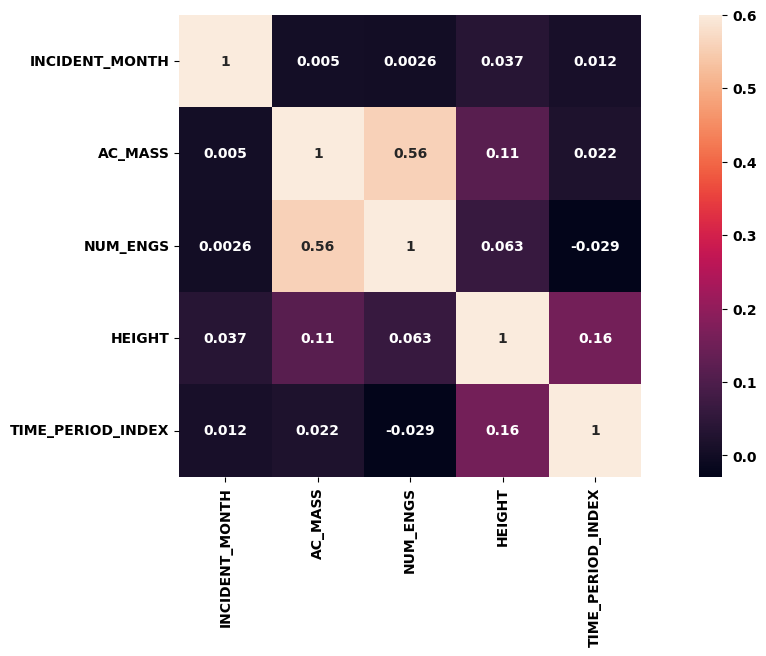

In [24]:
plt.figure(figsize=(15,6))
sns.heatmap(df_main[measure_cols].corr(), vmax=0.6, square=True, annot=True)

AC_MASS and NUM_ENGS:
- no surprise here - the bigger the aircraft, the more engines it is likely to have. Slightly surprised the correlation is not stronger

Everything else:
- uncorrelated

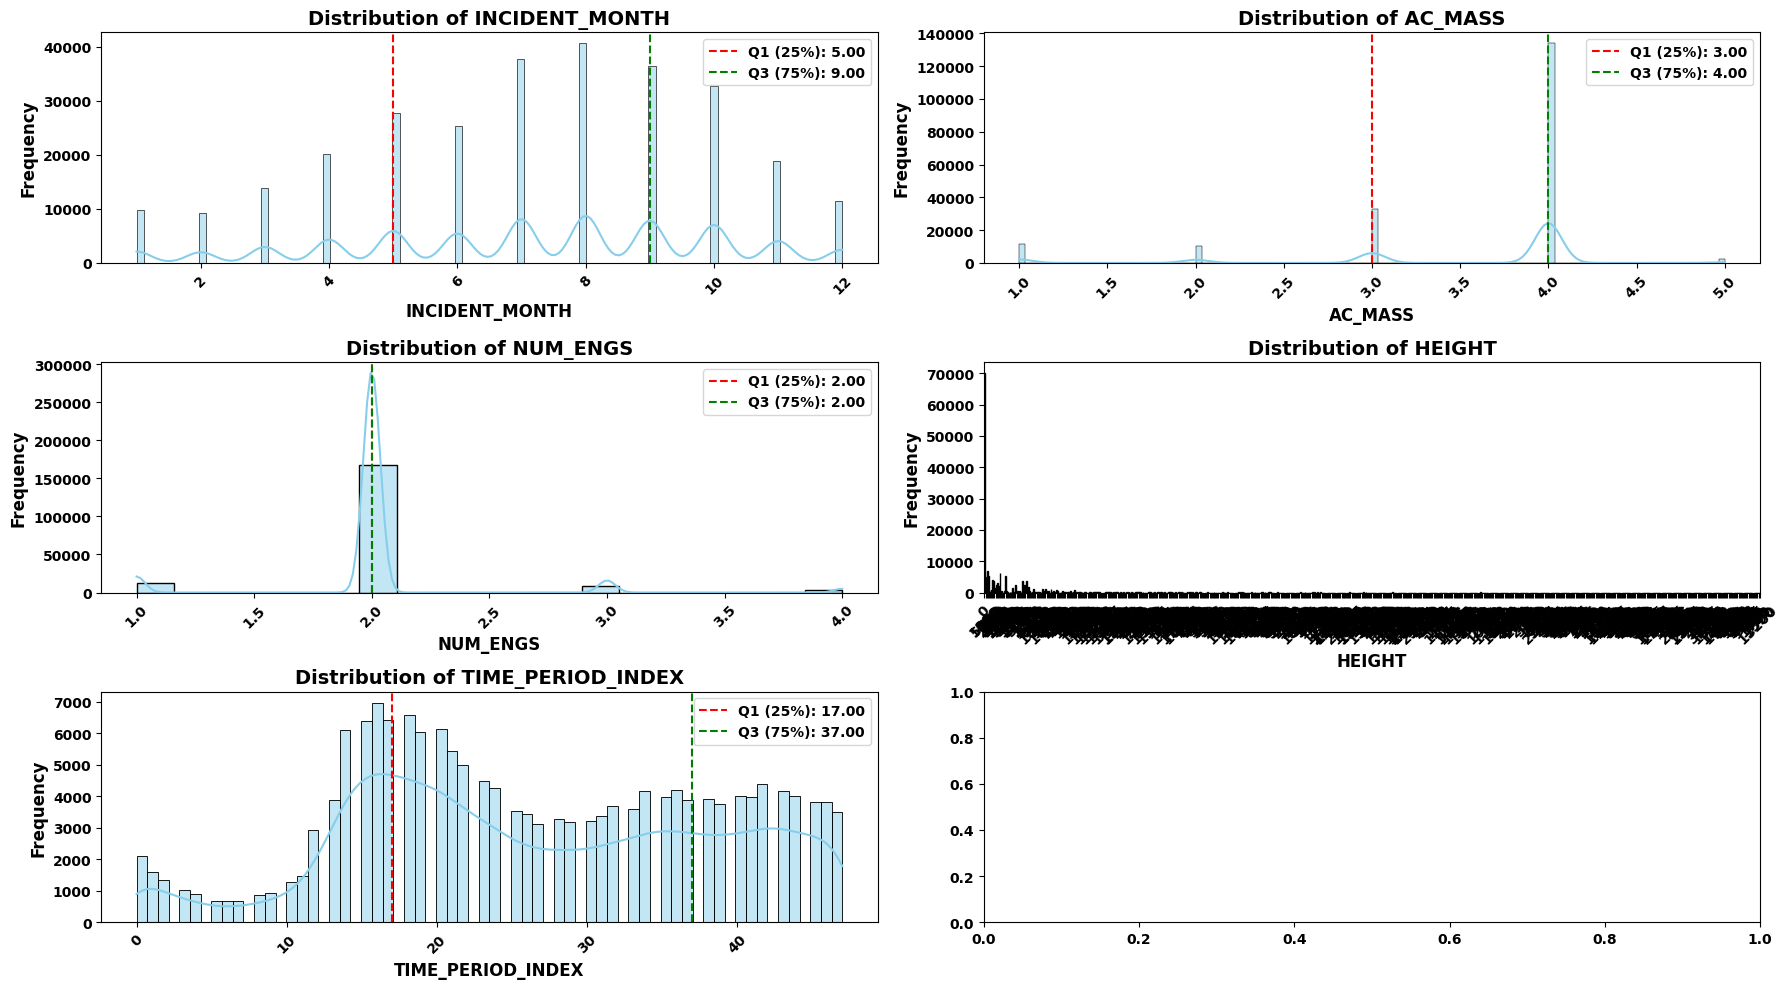

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(measure_cols):
    if pd.api.types.is_numeric_dtype(df_main[col]):
        q1 = df_main[col].quantile(0.25)
        q3 = df_main[col].quantile(0.75)
        
        sns.histplot(df_main[col], kde=True, ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].axvline(q1, color='red', linestyle='--', label=f'Q1 (25%): {q1:.2f}')
        axes[i].axvline(q3, color='green', linestyle='--', label=f'Q3 (75%): {q3:.2f}')
        axes[i].legend()
        
    else:
        sns.countplot(
            data=df_main, 
            x=col, 
            hue=col,       
            ax=axes[i], 
            palette='cool', 
            edgecolor='black', 
            legend=False   
        )   
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)


plt.tight_layout()
plt.show()

In [26]:
end_time = datetime.now()

elapsed_time = end_time - start_time
print (f"Elapsed from start: {str(elapsed_time).split('.')[0]}; Time: {datetime.now().strftime(format='%Y-%m-%d %H:%M:%S')}")

Elapsed from start: 0:07:16; Time: 2025-09-16 20:03:20
